# <div align="center"> 花 </div>

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.23.1
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101


In [2]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display
from PIL import Image

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [3]:
dataset = 'rflowers6'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
images_path = os.path.join(data_root, 'imgs')
train_path = os.path.join(data_root, 'train')
test_path = os.path.join(data_root, 'test')

## 生成train.json, val.json, test.json文件

In [4]:
record_count = 0 
labels_images = {}
with os.scandir(images_path) as it:
    for label, entry in enumerate(it):
        if not entry.is_dir():
            break
        with os.scandir(entry.path) as it:
            tmp_files = []
            for elem in it:
                if not elem.path.endswith('.jpg'):
                    print(elem.path)
                    continue 
                tmp_files.append(elem.path)
            labels_images[entry.name] = tmp_files
            record_count += len(tmp_files)
names_ids = {y:x for x, y in enumerate(labels_images.keys())}
names_ids

/data/datasets/cv/rflowers6/imgs/dandelion/flickr.pyc
/data/datasets/cv/rflowers6/imgs/dandelion/flickr.py
/data/datasets/cv/rflowers6/imgs/dandelion/run_me.py


{'rose': 0, 'daisy': 1, 'sunflower': 2, 'dandelion': 3, 'tulip': 4}

In [5]:
train_images = {}
val_images = {}
test_images = {}

for lname, imgs in labels_images.items():
    n_total = len(imgs)
    offset1, offset2 = int(0.6 * n_total), int(0.8 * n_total)
    train_images[names_ids[lname]] = imgs[:offset1]
    val_images[names_ids[lname]] = imgs[offset1:offset2]
    test_images[names_ids[lname]] = imgs[offset2:]

In [7]:
def generate_json_file(data, file):
    prefix_len = len(data_root)
    items = []
    for label, paths in data.items():
        for p in paths:
            items.append({'image_path': p[prefix_len+1:], 'label': label})
    random.shuffle(items)
    with open(os.path.join(data_root, file), 'w') as fp:
        json.dump(items, fp)
    return len(items)
    
train_count = generate_json_file(train_images, 'train.json')
val_count = generate_json_file(val_images, 'val.json')
test_count = generate_json_file(test_images, 'test.json')
train_count, val_count, test_count, train_count + val_count + test_count, record_count

(2592, 865, 866, 4323, 4323)

## 演示

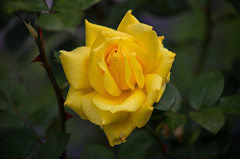

In [8]:
Image.open(train_images[0][0])

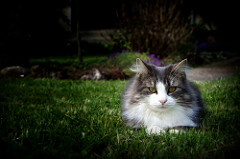

In [9]:
Image.open(train_images[1][0])

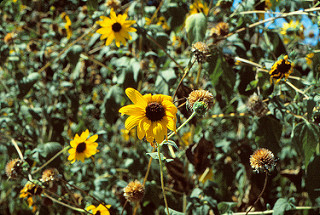

In [10]:
Image.open(train_images[2][0])

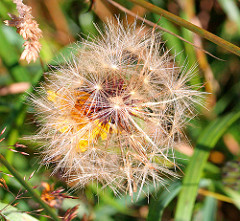

In [11]:
Image.open(train_images[3][0])

## 生成info.json

In [16]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles)

In [17]:
info = {
    'num_records': train_count + val_count + test_count,
    'num_classes': len(names_ids),
    'label_names': [ name for name in names_ids.keys()],
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, indent=4)
    
info

{'num_records': 4323,
 'num_classes': 5,
 'label_names': ['rose', 'daisy', 'sunflower', 'dandelion', 'tulip'],
 'mean': [0.4588, 0.4199, 0.3005],
 'std': [0.2477, 0.2201, 0.2253]}

## 数据平衡分析

<Figure size 432x288 with 0 Axes>

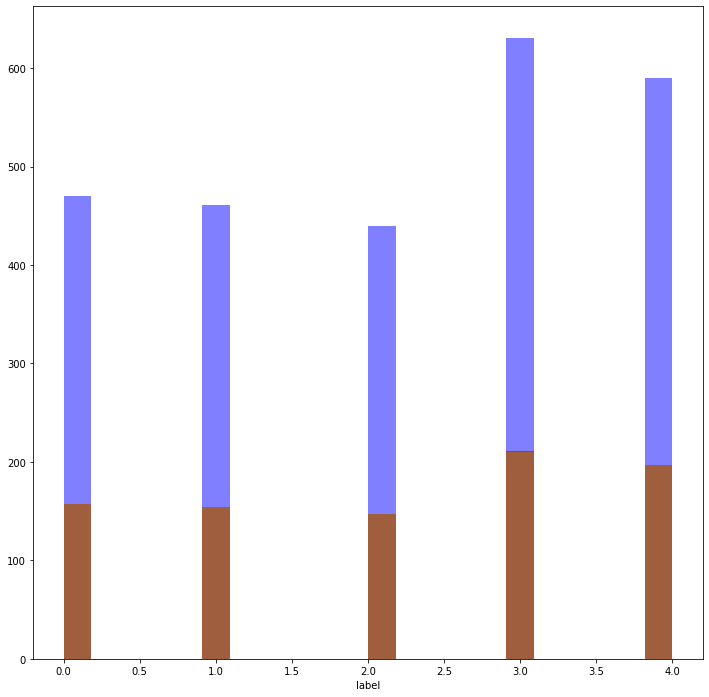

In [19]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 0.5), (df_test, 'maroon', 0.5)):
        sns.distplot(df['label'],
                 # fit=scipy.stats.norm,
                 kde=False,
                 hist=True,
                 hist_kws={"linewidth": 2, "alpha": alpha, 'color': co},
                 # rug=True,
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()